# Yandex Data Science School
## Linear Regression & Regularization Exercise.
### Written by Dr. Hanan Shteingart.

## Outline
In this exercise you will learn the following topics:

1. Refresher on how linear regression is solved in batch and in Gradient Descent 
2. Implementation of Ridge Regression
3. Comparing Ridge, Lasso and vanila Linear Regression on a dataset

## Refresher on Ordinary Least Square (OLS) aka Linear Regeression

### Lecture Note

In Matrix notration, the matrix $X$ is of dimensions $n \times p$ where is each row is an example and each column is a feature dimension. 

Similarily, $y$ is of dimension $n \times 1$ and $w$ is of dimensions $p \times 1$.

The model is $\hat{y}=X\cdot w$ where we assume for simplicity that $X$'s first columns equals to 1 (one padding), to account for the bias term.

Our objective is to optimize the loss $L$ defines as resiudal sum of squares (RSS): 

$L_{RSS}=\frac{1}{N}\left\Vert Xw-y \right\Vert^2$ (notice that in matrix notation this means summing over all examples, so $L$ is scalar.)

To find the optimal $w$ one needs to derive the loss with respect to $w$.

$\frac{\partial{L_{RSS}}}{\partial{w}}=\frac{2}{N}X^T(Xw-y)$ (to see why, read about [matrix derivatives](http://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf) or see class notes )

Thus, the gardient descent solution is $w'=w-\eta \frac{2}{N}X^T(Xw-y)$.

Solving $\frac{\partial{L_{RSS}}}{\partial{w}}=0$ for $w$ one can also get analytical solution:

$w_{OLS}=(X^TX)^{-1}X^Ty$

The first term, $(X^TX)^{-1}X^T$ is also called the pseudo inverse of $X$.

See [lecture note from Stanford](https://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf) for more details.


## Exercise 1 - Ordinary Least Square
* Get the boston housing dataset by using the scikit-learn package. hint: [load_boston](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html)

* What is $p$? what is $n$ in the above notation? hint: [shape](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.shape.html)

* write a model `OrdinaryLinearRegression` which has a propoery $w$ and 3 methods: `fit`, `predict` and `score` (which returns the MSE on a given sample set). Hint: use [numpy.linalg.pinv](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.pinv.html) to be more efficient.

* Fit the model. What is the training MSE?

* Plot a scatter plot where on x-axis plot $Y$ and in the y-axis $\hat{Y}_{OLS}$

* Split the data to 75% train and 25% test 20 times. What is the average MSE now for train and test? Hint: use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) or [ShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html).

* Use a t-test to proove that the MSE for training is significantly smaller than for testing. What is the p-value? Hint: use [scipy.stats.ttest_rel](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_rel.html). 

* Write a new class `OrdinaryLinearRegressionGradientDescent` which inherits from `OrdinaryLinearRegression` and solves the problem using gradinet descent. The class should get as a parameter the learning rate and number of iteration. Plot the class convergance. What is the effect of learning rate? How would you find number of iteration automatically? Note: Gradient Descent does not work well when features are not scaled evenly (why?!). Be sure to normalize your features first.

* **Bonus:** Repeat for coordinate descent by creating a new class `OrdinaryLinearRegressionCoordinateDescent` which also inherits from `OrdinaryLinearRegression`. Compare the learning curves.


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [29]:
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression

boston = load_boston()
# print (boston.DESCR)  to get the description of the data
boston.data.shape

(506, 13)

In [37]:
X = boston.data
y = boston.target

In [40]:
class OrdinaryLinearRegression:
    def __init__(self):
        self.w = None
        
    def fit(self, X, y):
        (n, p) = X.shape
        X = np.append(np.ones((n, 1)), X, 1)
        self.w = np.linalg.pinv(X) @ y
    
    def predict(self, sample):
        if len(sample.shape) == 1:
            sample = np.append(1., sample)
        else:
            sample = np.append(np.ones((sample.shape[0], 1)), sample, 1)
        return sample @ self.w
    
    def score(self, X, y):
        (n, p) = X.shape
        X = np.append(np.ones((n, 1)), X, 1)
        errors = X @ self.w - y
        return np.mean(errors ** 2)

model = OrdinaryLinearRegression()
model.fit(X, y)

print('score:', model.score(X, y))
model.predict(np.ones(13))

y_predicted = model.predict(X)

score: 21.8977792177


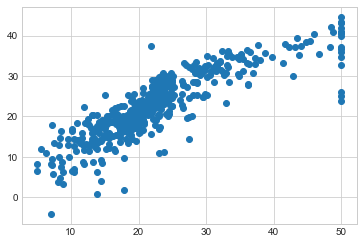

In [42]:
plt.scatter(y, y_predicted)

In [128]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
model = OrdinaryLinearRegression()
model.fit(X_train, y_train)
print(model.score(X_train, y_train), model.score(X_test, y_test))

24.3158139631 17.1584986495


In [50]:
from scipy import stats

def find_errors():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    model = OrdinaryLinearRegression()
    model.fit(X_train, y_train)
    return model.score(X_train, y_train), model.score(X_test, y_test)

all_results = [find_errors() for i in range(100)]
err_train, err_test = zip(*all_results)

stats.ttest_rel(err_train,err_test)

Ttest_relResult(statistic=-3.1319711579331573, pvalue=0.0022835214286021414)

In [81]:
class OrdinaryLinearRegressionGradientDescent(OrdinaryLinearRegression):
    def __init__(self, learning_rate=1, num_iterations=20):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.w = None
        self.error_history = None
        
    def fit(self, X, y):
        (n, p) = X.shape
        X = np.append(np.ones((n, 1)), X, 1)
        
        # Normalize
        maxima = np.max(np.abs(X), 0)
        X /= maxima

        w = np.zeros(p + 1)
        self.error_history = []
        for i in range(self.num_iterations):
            error = X @ w - y
            self.error_history.append(np.mean(error ** 2))
            w -= (self.learning_rate / n) * (error @ X)
        
        error = X @ w - y
        self.error_history.append(np.mean(error ** 2))
        self.w = w / maxima
        
    def get_error_history(self):
        return self.error_history
        
model2 = OrdinaryLinearRegressionGradientDescent(0.05)
model2.fit(X, y)
print('score:', model2.score(X, y))

score: 88.4553380915


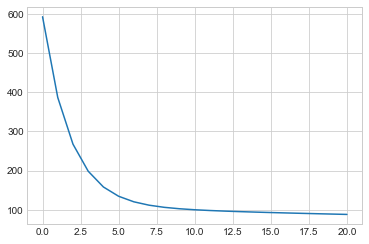

In [84]:
plt.plot(model2.get_error_history())

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
model2 = OrdinaryLinearRegressionGradientDescent(0.05)
model2.fit(X_train, y_train)
print(model2.score(X_train, y_train), model2.score(X_test, y_test))

92.0056240118 77.4907187927


## Exercise 2 - Ridge Linear Regression

Recall that ridge regression is identical to OLS but with a L2 penalty over the weights:

$L(y,\hat{y})=\frac{1}{N}\sum_{i=1}^{i=N}{(y^{(i)}-\hat{y}^{(i)})^2} + \lambda \left\Vert w \right\Vert_2$

* Show, by differentiating the above loss, that the analytical solution is $w_{Ridge}=(X^TX+\lambda I)^{-1}X^Ty$
* Change `OrdinaryLinearRegression` and `OrdinaryLinearRegressionGradientDescent` classes to work also for ridge regression (do not use the random noise analogy but use the analytical derivation). Either add a parameter, or use inheritance.
* **Bonus: Noise as a regularizer**: Show that OLS (ordinary least square), if one adds multiplicative noise to the features the **average** solution for $W$ is equivalent to Ridge regression. In other words, if $X'= X*G$ where $G$ is an uncorrelated noise with variance $\sigma$ and mean 1, then solving for $X'$ with OLS is like solving Ridge for $X$. What is the interpreation? 



OLS score: 21.8977792177
RLS score: 22.2893454948
Gradient descent score: 74.5550649225
Ridge gradient descent score: 74.6035213457


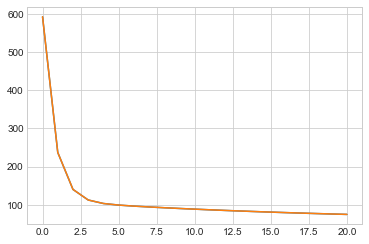

In [144]:
class LinearRegression:
    def __init__(self, lam=0):
        self.w = None
        self.lam = lam
           
    def predict(self, sample):
        if len(sample.shape) == 1:
            sample = np.append(1., sample)
        else:
            sample = np.append(np.ones((sample.shape[0], 1)), sample, 1)
        return sample @ self.w
    
    def score(self, X, y):
        (n, p) = X.shape
        X = np.append(np.ones((n, 1)), X, 1)
        errors = X @ self.w - y
        return np.mean(errors ** 2)
    
class OrdinaryLinearRegression(LinearRegression):
    def __init__(self, lam=0):
        super().__init__(lam)
        
    def fit(self, X, y):
        (n, p) = X.shape
        X = np.append(np.ones((n, 1)), X, 1)
        if self.lam == 0:
            pseudo_inverse = np.linalg.pinv(X)
        else:
            X_t = X.transpose()
            pseudo_inverse = np.linalg.inv(X_t @ X + self.lam * np.eye(p + 1)) @ X_t
        self.w = pseudo_inverse @ y
        
class OrdinaryLinearRegressionGradientDescent(OrdinaryLinearRegression):
    def __init__(self, lam=0, learning_rate=1, num_iterations=20):
        super().__init__(lam)
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.error_history = None
        
    def fit(self, X, y):
        (n, p) = X.shape
        X = np.append(np.ones((n, 1)), X, 1)
        
        # Normalize
        maxima = np.max(np.abs(X), 0)
        X /= maxima

        w = np.zeros(p + 1)
        self.error_history = []
        for i in range(self.num_iterations):
            error = X @ w - y
            self.error_history.append(np.mean(error ** 2))
            w -= (self.learning_rate / n) * (error @ X + 2 * self.lam * w)
        
        error = X @ w - y
        self.error_history.append(np.mean(error ** 2))
        self.w = w / maxima
        
    def get_error_history(self):
        return self.error_history
        
model = OrdinaryLinearRegression()
model.fit(X, y)
print('OLS score:', model.score(X, y))

model = OrdinaryLinearRegression(lam=0.5)
model.fit(X, y)
print('RLS score:', model.score(X, y))

model = OrdinaryLinearRegressionGradientDescent(learning_rate=0.1)
model.fit(X, y)
print('Gradient descent score:', model.score(X, y))
ordinary_history = model.get_error_history()

model = OrdinaryLinearRegressionGradientDescent(learning_rate=0.1, lam=0.5)
model.fit(X, y)
print('Ridge gradient descent score:', model.score(X, y))
ridge_history = model.get_error_history()

n = len(ordinary_history)

plt.plot(range(n), ordinary_history, range(n), ridge_history)

## Exercise 3 - Lasso Linear Regression

As we've seen in class, Lasso Regression is a regularization technique with $L_1$ penalty on weights. This techniques creates sparse weights (some weights become effectively zero). Programming a Lasso solver is a challange and is left as an optional exercise below.
This exercise will focus on the analysis of the different regularization techniques over a toy problem using the scikit-learn implementation.

### Data generation: 1-D Polynomal Regression
```
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 30
degrees = [1, 4, 15]
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

```

* Use the preprocessing transformer `sklearn.preprocessing.PolynomialFeatures` in order to create a feature space. Note, you can use `sklearn.pipeline.Pipeline` in order to create an effective model which does the preprocessing (not essential).
* Use `sklearn.model_selection.cross_val_score` to evaluate each of the linear model provided by Scikit-learn (`from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV`) and compare the performance over the different `degrees`. To do so, create a 3x3 plot where each row correspond to one model and each column to one degree. Each plot should plot the train data as well as the true model and the fitted one (use 100 points in the range [0,1]) and the CV (cross validation) MSE. What is the take home message? (Note: RidgeCV and LassoCV do an internal cross-validation to determin the regularization parameter.)
* Weights spectrum: change the `alpha` parameter gradually (on a logartithmic scale) and observe how the coefficients change for `degrees=5` over alpha for Ridge and Lasso. What is the take home message?